In [59]:
import cl_graph_bert as cgm
import torch
from torch import nn
import json
from transformers import BertModel, BertConfig, BertTokenizer, AdamW
import tqdm
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import dgl
g = dgl.load_graphs("./graphs/industrial_and_scientific_5_core_new.dgl")[0][0]

In [2]:
model = cgm.CLIPGraphModel(
    rel_types = g.etypes,
    emb_types = {x: g.number_of_nodes(x) for x in g.ntypes} 
)

device = "cuda"

model.load_state_dict(torch.load("./base_statedict_3.1703879752973503.pt", map_location=torch.device('cuda')))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CLIPGraphModel(
  (graph_model): StochasticTwoLayerRGCN(
    (embed): HeteroEmbedding(
      (embeds): ModuleDict(
        (Brand): Embedding(1900, 512)
        (Customer): Embedding(11041, 512)
        (Product): Embedding(5334, 512)
        (Review): Embedding(77060, 512)
      )
    )
    (conv1): HeteroGraphConv(
      (mods): ModuleDict(
        (rev_SOLD_BY): GraphConv(in=512, out=256, normalization=both, activation=None)
        (WROTE): GraphConv(in=512, out=256, normalization=both, activation=None)
        (SOLD_BY): GraphConv(in=512, out=256, normalization=both, activation=None)
        (rev_REVIEW_OF): GraphConv(in=512, out=256, normalization=both, activation=None)
        (REVIEW_OF): GraphConv(in=512, out=256, normalization=both, activation=None)
        (rev_WROTE): GraphConv(in=512, out=256, normalization=both, activation=None)
      )
    )
    (conv2): HeteroGraphConv(
      (mods): ModuleDict(
        (rev_SOLD_BY): GraphConv(in=256, out=256, normalization=both, activ

In [6]:
model.graph_model.embed({'Review': torch.tensor([22, 24])})['Review'].shape

torch.Size([2, 512])

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import tqdm

bert_base = BertModel.from_pretrained('bert-base-uncased')
device = "cuda"

bert_base.to(device)
model.language_model.to(device)
model.graph_model.to(device)
g.to(device)

reivew_ids = []

gnn_embs = []
bert_base_embs = []
bert_finetuned_embs = []

with torch.no_grad():
    for i in tqdm.tqdm(range(g.num_nodes('Product'))):
        review_id = g.successors(i, 'rev_REVIEW_OF').to(device)
        
        if len(review_id) > 1 and len(review_id) < 650:

            reivew_ids.append(review_id)
            
            gnn_emb = model.graph_model.embed({'Review': review_id})['Review'].detach().cpu().numpy()
            
            base_bert_emb = bert_base(input_ids = g.nodes["Review"].data['input_ids'][review_id].to(device), 
               attention_mask=g.nodes["Review"].data['attention_mask'][review_id].to(device), 
               token_type_ids=g.nodes["Review"].data['token_type_ids'][review_id].to(device)).last_hidden_state[:,0].type(torch.float64).detach().cpu().numpy()
            
            bert_finetuned_emb = model.language_model(input_ids = g.nodes["Review"].data['input_ids'][review_id].to(device), 
               attention_mask=g.nodes["Review"].data['attention_mask'][review_id].to(device), 
               token_type_ids=g.nodes["Review"].data['token_type_ids'][review_id].to(device)).last_hidden_state[:,0].type(torch.float64).detach().cpu().numpy()

            gnn_embs.append( gnn_emb )
            bert_base_embs.append( base_bert_emb )
            bert_finetuned_embs.append( bert_finetuned_emb )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████████| 5334/5334 [14:01<00:00,  6.34it/s]


In [69]:
X_gnn = torch.cat([torch.tensor(emb) for emb in gnn_embs])
X_base_bert = torch.cat([torch.tensor(emb) for emb in bert_base_embs])
X_bert_finetuned = torch.cat([torch.tensor(emb) for emb in bert_finetuned_embs])

X_lm = torch.cat([X_base_bert, X_bert_finetuned]).numpy()

In [71]:
TSNE_lm_emb = TSNE(n_components=2, init='random').fit_transform(X_lm)

In [76]:
style = np.zeros(len(X_lm))
style[148504//2:] = 1

Text(0.5, 1.0, 'TSNE Plot of BERT embeddings for modal verbs.')

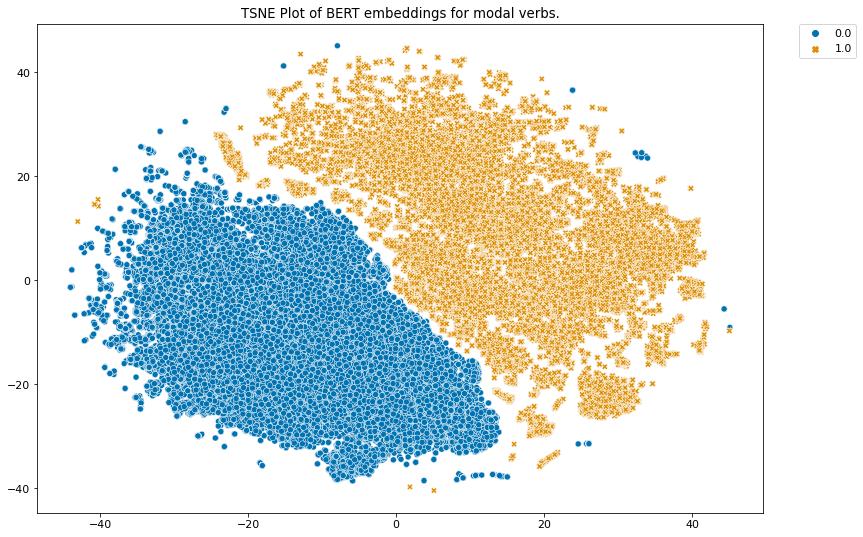

In [77]:
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(13, 9))
sns.scatterplot(
    x = TSNE_lm_emb[:,0],
    y = TSNE_lm_emb[:,1],
    hue = style,
    style = style,
    palette = sns.color_palette("colorblind", 2)

)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('TSNE Plot of BERT embeddings for modal verbs.')

In [72]:
TSNE_lm_emb.shape

(148504, 2)